# Ανάλυση Γονιδιακής Έκφρασης από GEO (Καρκίνος Πνεύμονα) Ανάλυση δεδομένων από GEO datasets (GSE43458, GSE31210, GSE19804) με στόχο την ταυτοποίηση σημαντικών γονιδίων στον καρκίνο του πνεύμονα.


# Φόρτωση GEO Datasets

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Φόρτωση datasets
df1 = pd.read_csv("https://ftp.ncbi.nlm.nih.gov/geo/series/GSE31nnn/GSE31210/matrix/GSE31210_series_matrix.txt.gz",
                  compression='gzip', sep='\t', comment='!', low_memory=False)

df2 = pd.read_csv("https://ftp.ncbi.nlm.nih.gov/geo/series/GSE19nnn/GSE19804/matrix/GSE19804_series_matrix.txt.gz",
                  compression='gzip', sep='\t', comment='!', low_memory=False)

# Εύρεση Κοινών Γονιδίων και Προεπεξεργασία

In [4]:
# Βεβαιώνουμε ότι η πρώτη στήλη (ID_REF) είναι κοινή και στα τρία datasets
genes_1 = set(df1['ID_REF'])
genes_2 = set(df2['ID_REF'])

In [5]:
common_genes = genes_1.intersection(genes_2)

In [6]:
# Φιλτράρισμα των datasets μόνο για κοινά γονίδια
df1_filtered = df1[df1['ID_REF'].isin(common_genes)].set_index('ID_REF')
df2_filtered = df2[df2['ID_REF'].isin(common_genes)].set_index('ID_REF')

In [7]:
# Ταξινόμηση index ώστε να είναι ακριβώς ίδια σειρά
df1_filtered = df1[df1['ID_REF'].isin(common_genes)].set_index('ID_REF').sort_index()
df2_filtered = df2_filtered.sort_index()

In [8]:
# Τελικός έλεγχος για την ταύτιση index
assert all(df1_filtered.index == df2_filtered.index)

In [9]:
# Συνένωση των δεδομένων
df_combined = pd.concat([df1_filtered, df2_filtered,], axis=1)

# Έλεγχος Τύπου Αναγνωριστικών (ID_REF)

In [10]:
print("GSE43458 IDs:", df1['ID_REF'].head())
print("GSE31210 IDs:", df2['ID_REF'].head())



GSE43458 IDs: 0    1007_s_at
1      1053_at
2       117_at
3       121_at
4    1255_g_at
Name: ID_REF, dtype: object
GSE31210 IDs: 0    1007_s_at
1      1053_at
2       117_at
3       121_at
4    1255_g_at
Name: ID_REF, dtype: object


# Μετατροπή Αναγνωριστικών σε Gene Symbols

In [11]:
# Φόρτωσε το αρχείο που κατέβασες
annotation = pd.read_csv("datasets\GPL570-55999.txt", sep="\t", comment='#', low_memory=False)

# Δες ποιες στήλες έχει
print(annotation.columns)


Index(['ID', 'GB_ACC', 'SPOT_ID', 'Species Scientific Name', 'Annotation Date',
       'Sequence Type', 'Sequence Source', 'Target Description',
       'Representative Public ID', 'Gene Title', 'Gene Symbol',
       'ENTREZ_GENE_ID', 'RefSeq Transcript ID',
       'Gene Ontology Biological Process', 'Gene Ontology Cellular Component',
       'Gene Ontology Molecular Function'],
      dtype='object')


In [12]:
# Δημιουργούμε ένα λεξικό probe → gene
id_to_gene = dict(zip(annotation['ID'], annotation['Gene Symbol']))

# Εφαρμόζεις αυτό το mapping στα datasets GSE31210 και GSE19804
df2['Gene_Symbol'] = df2['ID_REF'].map(id_to_gene)
df1['Gene_Symbol'] = df1['ID_REF'].map(id_to_gene)


# Ομαδοποίηση Ανά Γονίδιο και Υπολογισμός Έκφρασης


In [13]:
# Βήμα 1: Κρατάμε μόνο τις αριθμητικές στήλες (δηλαδή τα δείγματα)
df2_numeric = df2.select_dtypes(include='number')
df1_numeric = df1.select_dtypes(include='number')

# Βήμα 2: Προσθέτουμε ξανά τα gene symbols ως στήλη
df2_numeric['Gene_Symbol'] = df2['Gene_Symbol']
df1_numeric['Gene_Symbol'] = df1['Gene_Symbol']

# Βήμα 3: Κάνουμε groupby και υπολογίζουμε τον μέσο όρο για κάθε γονίδιο
df2_grouped = df2_numeric.groupby('Gene_Symbol').mean()
df1_grouped = df1_numeric.groupby('Gene_Symbol').mean()


# Τελική Συνένωση Όλων των Δεδομένων


In [14]:
# Συνένωση κατά γονίδιο (γραμμές), οι στήλες (δείγματα) δεν επαναλαμβάνονται
combined_df = pd.concat([df2_grouped, df1_grouped], axis=1)

# Δες τι φτιάξαμε
print(combined_df.shape)
combined_df.head()


(23520, 366)


,GSM494556,GSM494557,GSM494558,GSM494559,GSM494560,GSM494561,GSM494562,GSM494563,GSM494564,GSM494565,...,GSM773776,GSM773777,GSM773778,GSM773779,GSM773780,GSM773781,GSM773782,GSM773783,GSM773784,GSM773785
Gene_Symbol,,,,,,,,,,,,,,,,,,,,,
A1BG,6.376000,6.514450,6.935300,7.987240,7.931680,7.531040,6.922500,7.628280,7.24020,7.267070,...,50.813641,51.982870,46.984982,24.260811,50.404438,52.734867,52.912245,43.067164,40.169184,7.322948
A1BG-AS1,5.315020,5.032750,5.461360,5.812140,5.953150,5.800370,5.302210,5.581330,5.49403,5.342650,...,61.151523,76.560795,91.945839,68.984255,7.022719,51.320599,14.745603,64.812755,119.829274,8.107551
A1CF,7.397725,5.081705,4.759180,4.592725,4.652410,4.582735,4.886370,4.365795,4.51583,4.965115,...,25.849430,33.761611,47.827019,42.357287,26.442560,46.527127,33.422373,51.864429,31.129011,41.863779
A2M,9.548500,9.202655,9.744765,9.553915,9.420875,9.600145,8.897035,8.928620,9.50293,9.243995,...,8782.817786,9298.270346,9957.928594,9745.025715,9916.936047,9662.780993,10082.322964,13647.352951,7967.622052,10045.380457
A2M-AS1,6.206260,6.284620,8.054770,5.698790,6.214340,6.526420,4.727290,6.217280,7.03301,5.977370,...,295.488500,392.521100,373.392300,363.744200,279.185600,327.063400,473.129400,420.205500,284.472400,460.258800


# φορτώση δεδομένων και οργάνωση για ανάλυση

In [15]:
# Διαβάζει τα sample IDs
def load_clean_ids(path):
    with open(path, 'r') as f:
        return [line.strip().replace('"', '') for line in f if line.strip()]

cancer_samples = load_clean_ids(r"cancer-normal/cancer.txt")
normal_samples = load_clean_ids(r"cancer-normal/normal.txt")

# Φιλτράρει όσα υπάρχουν στο combined_df
cancer_samples = [s for s in cancer_samples if s in combined_df.columns]
normal_samples = [s for s in normal_samples if s in combined_df.columns]

print(f"Καρκινικά δείγματα: {len(cancer_samples)}")
print(f"Φυσιολογικά δείγματα: {len(normal_samples)}")


labels = pd.Series(
    ['cancer'] * len(cancer_samples) + ['normal'] * len(normal_samples),
    index=cancer_samples + normal_samples,
    name='label'
)

# Τελικό dataset (δείγματα x γονίδια + label)
expression_data = combined_df[cancer_samples + normal_samples].T
expression_data['label'] = labels

# ✅ Επιβεβαίωση
print("Τελικό σχήμα:", expression_data.shape)
expression_data.head()


Καρκινικά δείγματα: 286
Φυσιολογικά δείγματα: 80
Τελικό σχήμα: (366, 23521)


Gene_Symbol,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A4GALT,A4GNT,AA06,...,ZYG11B,ZYX,ZZEF1,ZZZ3,abParts /// IGKC /// IGKV4-1 /// IGKV4-1,av27s1 /// TRAV39 /// TRAV39,hsa-let-7a-3 /// hsa-let-7b /// hsa-mir-4763 /// MIRLET7BHG /// RP4-695O20__B.10,hsa-let-7a-3 /// hsa-let-7b /// hsa-mir-4763 /// RP4-695O20__B.10,mir-223,label
GSM773540,47.90095,46.825111,72.714534,2228.911570,175.34674,22.831965,15.927107,12.925406,73.018596,101.416950,...,1030.160047,167.89290,345.420567,778.35785,6.886894,22.436699,13.242170,111.81361,13.521504,cancer
GSM773541,51.64328,8.059568,23.870435,4198.206655,142.80260,23.447401,31.932787,12.202017,46.112976,68.965219,...,2070.380533,487.50920,137.000604,1601.05855,528.101930,4.380360,4.805737,46.92550,105.879995,cancer
GSM773542,40.98813,10.234848,13.798074,4695.593220,142.81548,11.082931,31.783636,40.485352,51.898190,50.386010,...,1690.349143,384.43770,227.002517,1343.98745,210.150816,6.839572,3.302328,62.00354,205.846188,cancer
GSM773543,28.38625,8.138013,40.220118,6329.205170,106.75270,16.412923,39.129192,32.542745,19.044909,31.693239,...,2315.690700,330.22475,200.465752,1483.14315,262.979570,27.579258,9.878414,83.47410,21.877117,cancer
GSM773544,42.09003,10.482582,26.090287,3881.230130,240.99803,17.330212,23.747617,16.267970,32.913082,51.031890,...,1500.671390,274.26120,296.169413,1095.84360,609.263698,10.045916,2.294671,75.77886,17.893558,cancer


# PCA

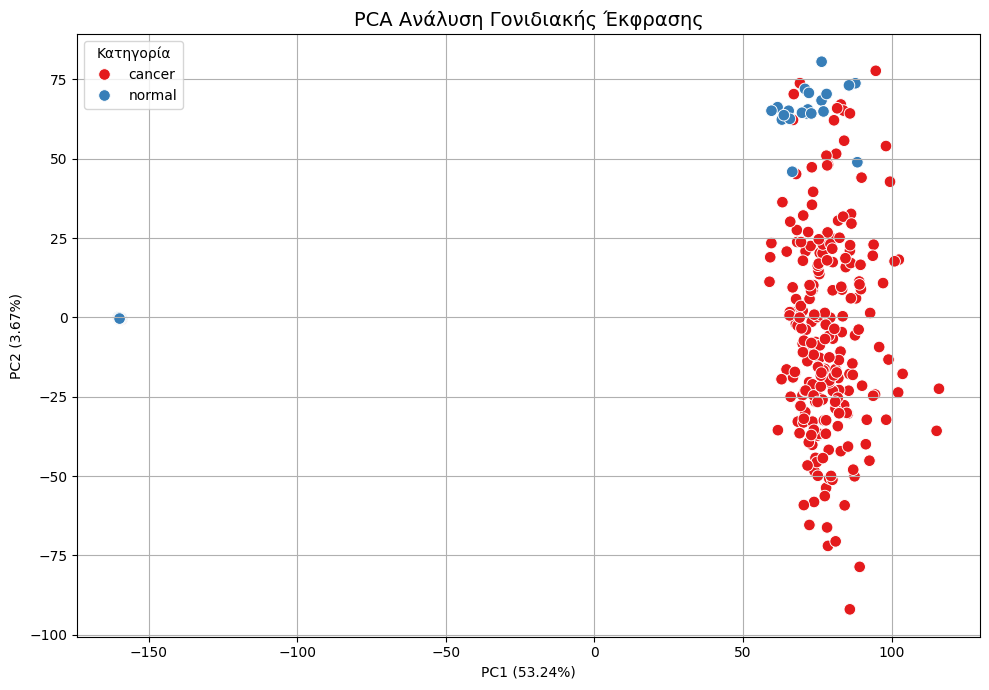

In [19]:
# 🔹 Χωρίζουμε features & labels
X = expression_data.drop(columns=['label'])
y = expression_data['label']

# 🔹 Κανονικοποίηση
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔹 PCA με 2 συνιστώσες
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 🔹 Δημιουργία DataFrame για plot
pca_df = pd.DataFrame(data=X_pca, columns=["PC1", "PC2"])
pca_df["label"] = y.values

# 🔹 Οπτικοποίηση
plt.figure(figsize=(10,7))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="label", palette="Set1", s=70)
plt.title("PCA Ανάλυση Γονιδιακής Έκφρασης", fontsize=14)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.legend(title="Κατηγορία")
plt.grid(True)
plt.tight_layout()
plt.show()
